In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
# load train data
train = pd.read_csv('microarray_train.csv', index_col=0)

# seprate target from features
target = train.pop('cancer')
print(train.shape)
train.head()

(38, 7129)


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [3]:
# label encode target, ALL:0, AML:1
le = LabelEncoder()
target = le.fit_transform(target)
print(le.classes_)

['ALL' 'AML']


#### Baseline Model

In [4]:
# baseline

# stratified 5 fold split of data
skf = StratifiedKFold(n_splits=5)
scores = []
for trainidx, testidx in skf.split(train, target):
    trainx, trainy = train.loc[trainidx, :], target[trainidx]
    testx, testy = train.loc[testidx], target[testidx]
    
    svcpipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(C=1))
    ])
    
    svcpipe.fit(trainx, trainy)
    scores.append(svcpipe.score(testx, testy))
    
print(f'Scores: {scores}')

Scores: [0.75, 0.75, 0.625, 0.7142857142857143, 0.7142857142857143]


In [5]:
# create metrics df
def generate_metrics(df,target):    
    metrics = pd.DataFrame()
    metrics['var'] = df.var()
    # compute percent of intensity values > 0 for esch feature
    metrics['pctvalpos'] = [sum(df[col]>0)/len(df[col]) for col in df.columns]
    # compute mutual info for features
    metrics['mi'] = mutual_info_classif(df, target)
    
    # compute regular p-values for each feature between ALL/0 and AML/1 
    pval=[]
    for col in df.columns:
        pval.append(stats.ttest_ind(df.loc[target==1,col], df.loc[target==0,col], equal_var=False)[1]) # store p-val
    metrics['pval'] = pval    
    return metrics

met = generate_metrics(train, target)
met.describe()


,var,pctvalpos,mi,pval
count,7.129000e+03,7129.000000,7129.000000,7.129000e+03
mean,6.820928e+05,0.712394,0.053151,3.426886e-01
std,3.845060e+06,0.354564,0.071880,3.082058e-01
min,4.769018e+02,0.000000,0.000000,8.388715e-09
25%,8.210373e+03,0.447368,0.000000,5.578156e-02
50%,3.170128e+04,0.921053,0.021937,2.591065e-01
75%,1.295735e+05,1.000000,0.084646,5.888123e-01
max,1.609285e+08,1.000000,0.537751,9.996315e-01


In [6]:
# drop features based on metrics
def dropfeat(df, metricsdf):
    dropcol = metricsdf[metricsdf['pctvalpos'] < 0.5].index
    dropcol = dropcol.append(metricsdf[metricsdf['pval'] > 0.001].index)
    dropcol = dropcol.append(metricsdf[metricsdf['mi'] < 0.3].index)
    
    dropcol = dropcol.unique()
    df = df.drop(dropcol, axis=1)
    #print(df.shape)
    return df

In [7]:
# generate list of correlated features to drop
def generate_corr(df, threshold, metricsdf):
    # set cut off threshold
    threshold = threshold
    # compute correlation matrix, take absolute value 
    corrmat = df.corr().abs() 
    
    # find feature pairs with correlation coefficients above threshold
    r = []
    c = []
    coeff = []
    for row in range(len(corrmat.columns)):
        for col in range(row): # stops at diagonal
            # check if above threshold
            if corrmat.iloc[row,col] >= threshold:
                # store row, column, coefficient
                r.append(row)
                c.append(col)
                coeff.append(corrmat.iloc[row,col])
                
    # make df with row and col pairs sorted by correlation coefficient
    corrdf = pd.DataFrame()
    corrdf['r'] = r
    corrdf['c'] = c
    corrdf['coeff'] = coeff
    #print(corrdf)
    # sort by coefficient
    corrdf = corrdf.sort_values(by=['coeff'], ascending=False)
    #print(corrdf)
    
    # choose correlated features to drop based on p-value
    corrcol = []
    for entry in range(len(corrdf)):
        row = corrdf.loc[entry,'r']
        col = corrdf.loc[entry,'c']
        # check which has higher mi score, if already in corrcol
        if metrics.loc[corrmat.columns[col],'pval'] > metrics.loc[corrmat.columns[row],'pval'] \
        and (corrmat.columns[col] not in corrcol):
            # add to corrcol list
            corrcol.append(corrmat.columns[col])
        elif metrics.loc[corrmat.columns[col],'pval'] < metrics.loc[corrmat.columns[row],'pval'] \
        and (corrmat.columns[row] not in corrcol):
            corrcol.append(corrmat.columns[row])
            
    return corrcol
#trainx = trainx.drop(corrcol, axis=1)


In [8]:
# stratified 5 fold split of data
skf = StratifiedKFold(n_splits=5)
scores = []
for trainidx, testidx in skf.split(train, target):
    trainx, trainy = train.loc[trainidx, :], target[trainidx]
    testx, testy = train.loc[testidx], target[testidx]
    
    # create metrics df, drop features based on metrics
    metrics = generate_metrics(trainx, trainy)
    trainx = dropfeat(trainx, metrics)
    testx = dropfeat(testx, metrics)
    #print(trainx.shape)
    
    # find correlated features, drop features
    corrcol = generate_corr(trainx, threshold=0.7, metricsdf=metrics)
    trainx = trainx.drop(corrcol, axis=1)
    testx = testx.drop(corrcol, axis=1)
    #print(trainx.shape)
    
    # model pipeline
    svcpipe = Pipeline([
        ('scaler', StandardScaler()),
        #('svc', SVC(C=1)),
        ('svc', SVC(C=1, class_weight='balanced'))
    ])   
    
    svcpipe.fit(trainx, trainy)
    scores.append(svcpipe.score(testx, testy))
    
print(f'Scores: {scores}')

Scores: [1.0, 0.875, 0.875, 1.0, 1.0]


(14, 14)


<AxesSubplot:>

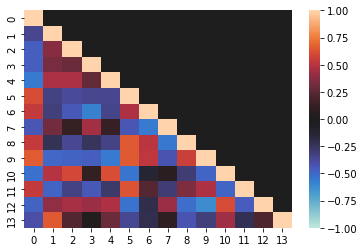

In [9]:
# check correlation of remaining features
corrmat = trainx.corr()
#print(corrmat)

print(corrmat.shape)
sns.heatmap(np.tril(corrmat), vmin=-1,vmax=1, center=0)

In [10]:
# parameter optimization test
skf = StratifiedKFold(n_splits=5)
scores = []
for trainidx, testidx in skf.split(train, target):
    trainx, trainy = train.loc[trainidx, :], target[trainidx]
    testx, testy = train.loc[testidx], target[testidx]
    
    # create metrics df, drop features based on metrics
    metrics = generate_metrics(trainx, trainy)
    trainx = dropfeat(trainx, metrics)
    testx = dropfeat(testx, metrics)
    #print(trainx.shape)
    
    # find correlated features, drop features
    corrcol = generate_corr(trainx, threshold=0.7, metricsdf=metrics)
    trainx = trainx.drop(corrcol, axis=1)
    testx = testx.drop(corrcol, axis=1)
    #print(trainx.shape)
    
    # model pipeline
    svcpipe = Pipeline([
        ('scaler', StandardScaler()),
        #('svc', SVC(C=1)),
        ('svc', SVC(C=0.25, class_weight='balanced'))
    ])   
    
    svcpipe.fit(trainx, trainy)
    scores.append(svcpipe.score(testx, testy))
    
print(f'Scores: {scores}')

Scores: [1.0, 0.875, 0.875, 1.0, 0.8571428571428571]


#### Final Model

In [11]:
# final model
trainx = pd.read_csv('microarray_train.csv', index_col=0)
trainy = trainx.pop('cancer')

testx = pd.read_csv('microarray_train.csv', index_col=0)
testy = testx.pop('cancer')

# label encode target, ALL:0, AML:1
le = LabelEncoder()
trainy = le.fit_transform(trainy)
testy = le.fit_transform(testy)
print(f'classes: {le.classes_}')

# create metrics df, drop features based on metrics
metrics = generate_metrics(trainx, trainy)
trainx = dropfeat(trainx, metrics)
testx = dropfeat(testx, metrics)
print(f'shape after metrics filter: {trainx.shape}')

# find correlated features, drop features
corrcol = generate_corr(trainx, threshold=0.7, metricsdf=metrics)
trainx = trainx.drop(corrcol, axis=1)
testx = testx.drop(corrcol, axis=1)
print(f'shape after correlation filter: {trainx.shape}')

# model pipeline
svcpipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=1, class_weight='balanced'))
])   

svcpipe.fit(trainx, trainy)
svcpipe.score(testx, testy)
    
print(f'Score: {svcpipe.score(testx, testy)}')

classes: ['ALL' 'AML']
shape after metrics filter: (38, 43)
shape after correlation filter: (38, 12)
Score: 1.0


(12, 12)


<AxesSubplot:>

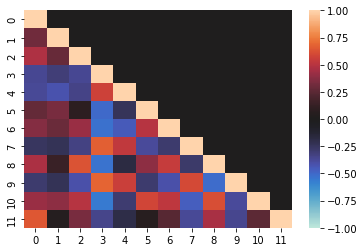

In [12]:
# check correlation of remaining features
corrmat = trainx.corr()
#print(corrmat)
print(corrmat.shape)
sns.heatmap(np.tril(corrmat), vmin=-1,vmax=1, center=0)

In [13]:
# remaining features
trainx.columns

Index(['D86479_at', 'D86983_at', 'L47738_at', 'M55150_at', 'M81933_at',
       'U28833_at', 'U53468_at', 'U82759_at', 'X59417_at', 'Y12670_at',
       'U22376_cds2_s_at', 'M12959_s_at'],
      dtype='object')

In [14]:
# gene descriptions of remaining features
gene_info = pd.read_csv('gene_info.csv', index_col=0)
#gene_info.head()
geneidx=[]
for genenum in trainx.columns:
    mask = gene_info['Gene Accession Number'].str.match(genenum)
    geneidx.append(list(gene_info[mask].index)[0])
    
print(geneidx)
gene_info.iloc[geneidx,:]

[653, 682, 1629, 2019, 2266, 2994, 3390, 3846, 4327, 5038, 5771, 6166]


,Gene Description,Gene Accession Number
653,Non-lens beta gamma-crystallin like protein (A...,D86479_at
682,KIAA0230 gene; partial cds,D86983_at
1629,Inducible protein mRNA,L47738_at
2019,FAH Fumarylacetoacetate,M55150_at
2266,CDC25A Cell division cycle 25A,M81933_at
2994,Down syndrome critical region protein (DSCR1) ...,U28833_at
3390,NADH:ubiquinone oxidoreductase subunit B13 (B1...,U53468_at
3846,GB DEF = Homeodomain protein HoxA9 mRNA,U82759_at
4327,PROTEASOME IOTA CHAIN,X59417_at
5038,LEPR Leptin receptor,Y12670_at
